# Neural Network

## Import libraries

In [249]:
import pandas as pd
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score

## Looking at the data

### One-vs-all encoding
For example: if our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

The code to covert the target vector.

In [250]:
def convert_y_to_vect(y, out_len):
    y_vect = np.zeros((len(y), out_len))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

In [251]:
def transform_and_split_data(data):
    X = data[:, :-1]
    y = data[:, -1]
    print(f'Original y hist: {np.histogram(y, range(int(y.max()) + 1))}')
    y = y - data[:, -1].min()
    y[y<=2] = 0.
    y[y==3] = 1.
    y[y>3] = 2.

    y_0 = (y[y==0][:np.count_nonzero(y==2)]).reshape((-1, 1))
    y_1 = (y[y==1][:np.count_nonzero(y==2)]).reshape((-1, 1))
    y_2 = (y[y==2]).reshape((-1, 1))

    X_0 = X[y==0][:np.count_nonzero(y==2)]
    X_1 = X[y==1][:np.count_nonzero(y==2)]
    X_2 = X[y==2]

    y = np.vstack((y_0, y_1, y_2)).reshape((-1, ))
    X = np.vstack((X_0, X_1, X_2))


    print(f'Current y hist: {np.histogram(y, [-0.5, 0.5, 1.5, 2.5])}')
    print(f'y min: {y.min()}, y max: {y.max()}')
    y_out_len = int(y.max()) + 1

    print(f'The shape of the wines dataset: {data.shape}')
    print(f'y[:10]:\n{y[:10]}')
    print(f'X[:10, :]:\n{X[:10, :]}')

    # Scale the dataset
    X_scale = StandardScaler()
    X = X_scale.fit_transform(X)
    print(f'ScaledX[:10, :]:\n{X[:10, :]}') # Looking the new features after scaling

    # Split the data into training and test set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Converting the training and test targets to vectors
    y_v_train = convert_y_to_vect(y_train, y_out_len)
    y_v_test = convert_y_to_vect(y_test, y_out_len)
    # Check to see that our code performs as we expect
    # print(y_train[0:10])
    # print(y_v_train[0:10])

    return X_train, y_v_train, X_test, y_test, y_out_len

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [252]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [253]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [254]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [255]:
def feed_forward(x, W, b, act_func):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = {} # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = act_func(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [256]:
def calculate_out_layer_delta(y, a_out, z_out, act_func_deriv):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * act_func_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l, act_func_deriv):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * act_func_deriv(z_l)

## The Back Propagation Algorithm


In [257]:
def train_nn(nn_structure, X, y, iter_num, act_func, act_func_deriv, l2_lambda=0, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b, act_func)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l], act_func_deriv)
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l], act_func_deriv)
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * ((1.0/N * tri_W[l]) + (l2_lambda * W[l]))
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers, act_func):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b, act_func)
        y[i] = np.argmax(a[n_layers])
    return y

### Plotting the learning curve


In [258]:
# plot the avg_cost_func
def plot_avg_cost(avg_cost_function, title):
    plt.plot(avg_cost_function)
    plt.title(title)
    plt.ylabel('Average J')
    plt.xlabel('Iteration number')
    plt.grid()
    plt.show()

### Confusion Matrix and Classification Analysis

In [259]:
def confusion_and_classification(y, y_hat):
    cm = confusion_matrix(y, y_hat, normalize='true')

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='winter')
    plt.show()

    cr = classification_report(y, y_hat, zero_division=0)
    # accuracy
    print(cr[: cr.find('accuracy') - 6])
    print(f'\t\t R2 Score: {r2_score(y, y_hat)}\n')

### Function to analyze different methods

In [260]:
def nn_performance(title, nn_structure, X_train, y_v_train, X_test, y_test, num_of_iter, act_func, act_func_deriv, l2_lambda=0):
    # train the NN
    print(f'{title}:')
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, num_of_iter, act_func, act_func_deriv, l2_lambda)
    # Print accuracy of method
    y_pred = predict_y(W, b, X_test, 3, act_func)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print('Prediction accuracy is {}%'.format(accuracy))
    confusion_and_classification(y_test, y_pred)
    # Display plot of average cost per iterations
    plot_avg_cost(avg_cost_func, title)

    folder = 'nn_logs/'
    date = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    np.save(folder+date+title+f'-{accuracy}'+'W', W)
    np.save(folder+date+title+f'-{accuracy}'+'b', b)
    np.save(folder+date+title+f'-{accuracy}'+'f', avg_cost_func)

### Other activation functions

In [261]:
def re_lu(z):
    z_cp = z.copy()
    z_cp[z_cp<0] = 0
    return z_cp

def re_lu_deriv(z):
    z_cp = z.copy()
    indices_under_zero = z_cp<0
    indices_over_zero = z_cp>=0
    z_cp[indices_under_zero] = 0
    z_cp[indices_over_zero] = 1
    return z_cp

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_deriv(z):
    return 1 - (tanh(z) ** 2)

def soft_plus(z):
    return np.log(1 + np.exp(z))

def soft_plus_deriv(z):
    return 1 / (1 + np.exp(-z))

# Train Neural Network

In [262]:
def train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len):
    num_of_iterations = 3000
    print(f'Number of samples: {X_train.shape[0] + X_test.shape[0]}')
    nn_structure = [X_train.shape[1], 6, y_out_len] # [11, 6, 3]
    l2_lambdas = [0.0001, 0.001, 0.01, 0.1]
    for l2_lambda in l2_lambdas:
        nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn_structure}',
                       nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)

    nn_structure = [X_train.shape[1], 13, y_out_len] # [11, 13, 3]
    for l2_lambda in l2_lambdas:
        nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn_structure}',
                       nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)

    nn_structure = [X_train.shape[1], 6, y_out_len] # [11, 6, 3]
    for l2_lambda in l2_lambdas:
        nn_performance(f'Tanh, L2={l2_lambda}, Structure={nn_structure}',
                       nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, tanh, tanh_deriv, l2_lambda)

    nn_structure = [X_train.shape[1], 13, y_out_len] # [11, 13, 3]
    for l2_lambda in l2_lambdas:
        nn_performance(f'Tanh, L2={l2_lambda}, Structure={nn_structure}',
                       nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, tanh, tanh_deriv, l2_lambda)

In [263]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
data_red = df_red.to_numpy()

df_white = pd.read_csv('winequality-white.csv', sep=';')
data_white = df_white.to_numpy()

data_all = np.vstack((data_red, data_white))

rs = r.RandomState(42)
r.shuffle(data_red)
r.shuffle(data_white)
r.shuffle(data_all)

# Train Red Wines Data

In [264]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_red)

Original y hist: (array([  0,   0,   0,  10,  53, 681, 638, 217]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))
Current y hist: (array([217, 217, 217]), array([-0.5,  0.5,  1.5,  2.5]))
y min: 0.0, y max: 2.0
The shape of the wines dataset: (1599, 12)
y[:10]:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X[:10, :]:
[[8.4000e+00 6.5000e-01 6.0000e-01 2.1000e+00 1.1200e-01 1.2000e+01
  9.0000e+01 9.9730e-01 3.2000e+00 5.2000e-01 9.2000e+00]
 [7.2000e+00 1.0000e+00 0.0000e+00 3.0000e+00 1.0200e-01 7.0000e+00
  1.6000e+01 9.9586e-01 3.4300e+00 4.6000e-01 1.0000e+01]
 [9.2000e+00 5.4000e-01 3.1000e-01 2.3000e+00 1.1200e-01 1.1000e+01
  3.8000e+01 9.9699e-01 3.2400e+00 5.6000e-01 1.0900e+01]
 [9.6000e+00 5.0000e-01 3.6000e-01 2.8000e+00 1.1600e-01 2.6000e+01
  5.5000e+01 9.9722e-01 3.1800e+00 6.8000e-01 1.0900e+01]
 [7.9000e+00 3.5000e-01 2.1000e-01 1.9000e+00 7.3000e-02 4.6000e+01
  1.0200e+02 9.9640e-01 3.2700e+00 5.8000e-01 9.5000e+00]
 [8.4000e+00 5.6000e-01 4.0000e-02 2.0000e+00 8.2000e-02 1.0000e+01
  2.2000

Number of samples: 651
Sigmoid, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.541984732824424%


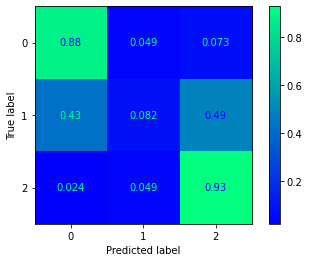

              precision    recall  f1-score   support

         0.0       0.62      0.88      0.73        41
         1.0       0.50      0.08      0.14        49
         2.0       0.58      0.93      0.72        41
		 R2 Score: 0.20731707317073167



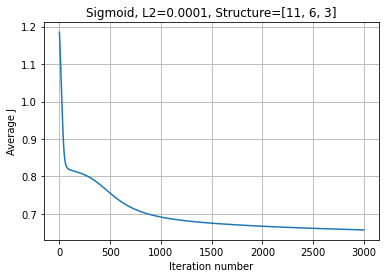

Sigmoid, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 58.778625954198475%


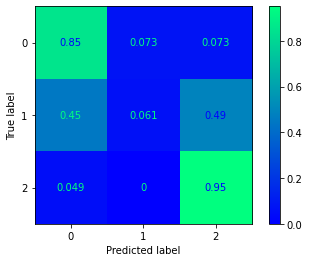

              precision    recall  f1-score   support

         0.0       0.59      0.85      0.70        41
         1.0       0.50      0.06      0.11        49
         2.0       0.59      0.95      0.73        41
		 R2 Score: 0.1585365853658537



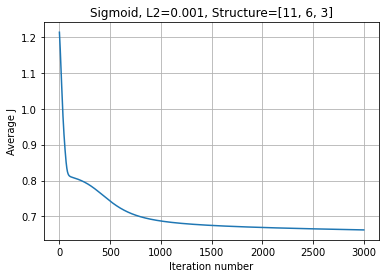

Sigmoid, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 54.961832061068705%


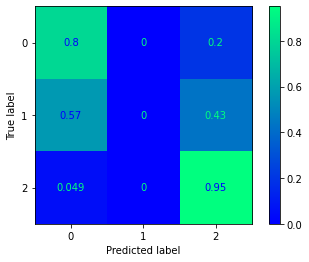

              precision    recall  f1-score   support

         0.0       0.52      0.80      0.63        41
         1.0       0.00      0.00      0.00        49
         2.0       0.57      0.95      0.72        41
		 R2 Score: -0.08536585365853666



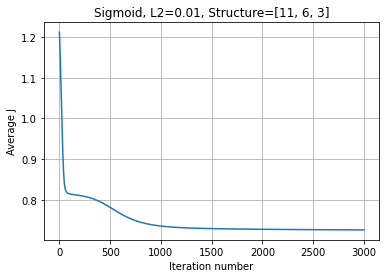

Sigmoid, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.297709923664126%


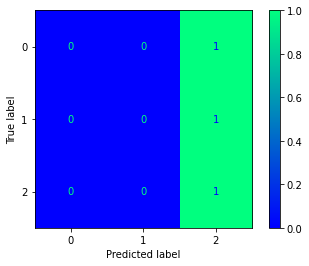

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        41
         1.0       0.00      0.00      0.00        49
         2.0       0.31      1.00      0.48        41
		 R2 Score: -1.5975609756097562



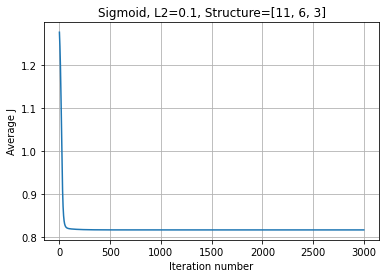

Sigmoid, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 61.832061068702295%


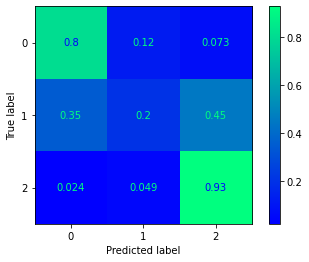

              precision    recall  f1-score   support

         0.0       0.65      0.80      0.72        41
         1.0       0.59      0.20      0.30        49
         2.0       0.60      0.93      0.73        41
		 R2 Score: 0.24390243902439024



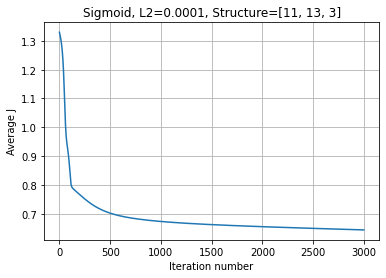

Sigmoid, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 58.778625954198475%


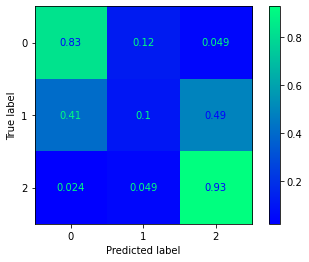

              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71        41
         1.0       0.42      0.10      0.16        49
         2.0       0.59      0.93      0.72        41
		 R2 Score: 0.23170731707317072



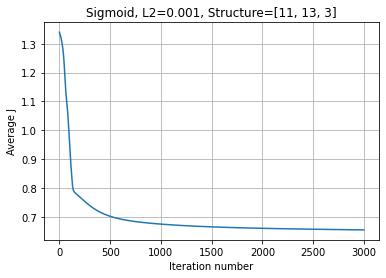

Sigmoid, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 54.961832061068705%


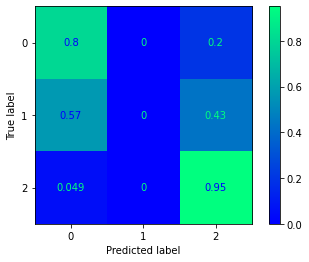

              precision    recall  f1-score   support

         0.0       0.52      0.80      0.63        41
         1.0       0.00      0.00      0.00        49
         2.0       0.57      0.95      0.72        41
		 R2 Score: -0.08536585365853666



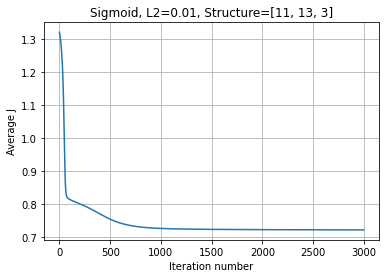

Sigmoid, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.297709923664126%


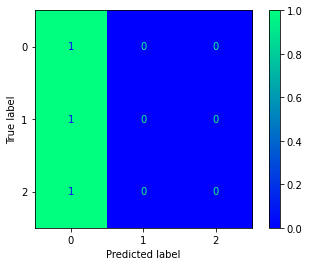

              precision    recall  f1-score   support

         0.0       0.31      1.00      0.48        41
         1.0       0.00      0.00      0.00        49
         2.0       0.00      0.00      0.00        41
		 R2 Score: -1.5975609756097562



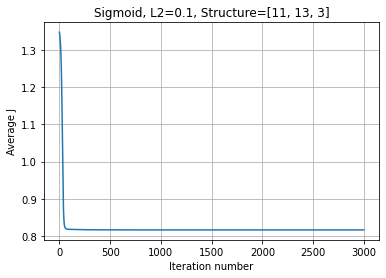

Tanh, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 63.358778625954194%


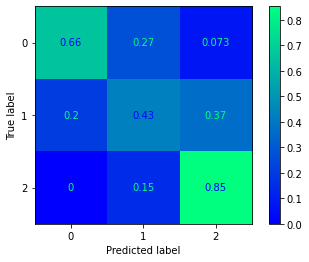

              precision    recall  f1-score   support

         0.0       0.73      0.66      0.69        41
         1.0       0.55      0.43      0.48        49
         2.0       0.62      0.85      0.72        41
		 R2 Score: 0.30487804878048785



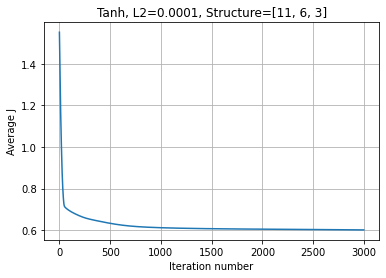

Tanh, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 61.06870229007634%


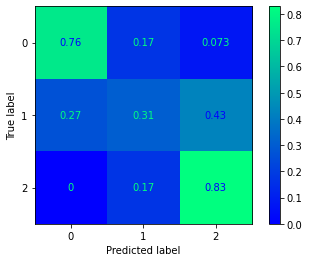

              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        41
         1.0       0.52      0.31      0.38        49
         2.0       0.59      0.83      0.69        41
		 R2 Score: 0.2682926829268293



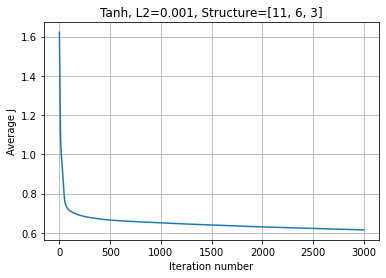

Tanh, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 60.30534351145038%


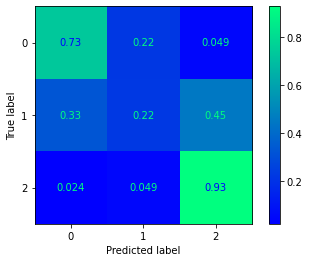

              precision    recall  f1-score   support

         0.0       0.64      0.73      0.68        41
         1.0       0.50      0.22      0.31        49
         2.0       0.61      0.93      0.74        41
		 R2 Score: 0.25609756097560976



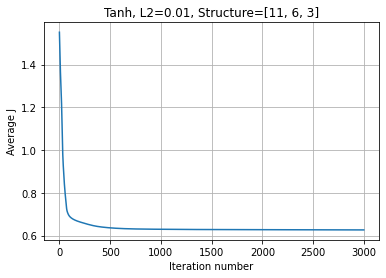

Tanh, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.48854961832062%


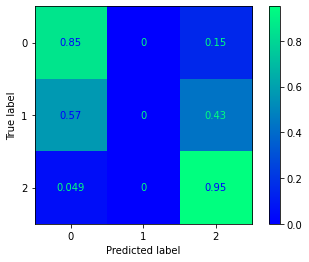

              precision    recall  f1-score   support

         0.0       0.54      0.85      0.66        41
         1.0       0.00      0.00      0.00        49
         2.0       0.59      0.95      0.73        41
		 R2 Score: 0.012195121951219523



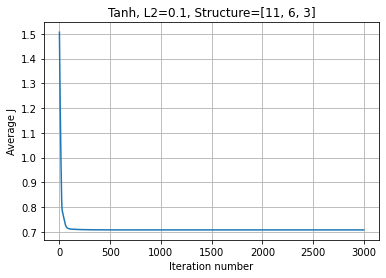

Tanh, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 65.64885496183206%


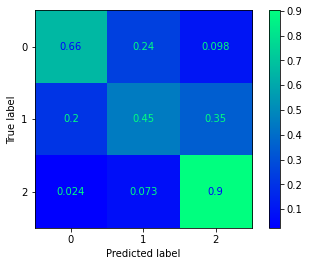

              precision    recall  f1-score   support

         0.0       0.71      0.66      0.68        41
         1.0       0.63      0.45      0.52        49
         2.0       0.64      0.90      0.75        41
		 R2 Score: 0.2682926829268293



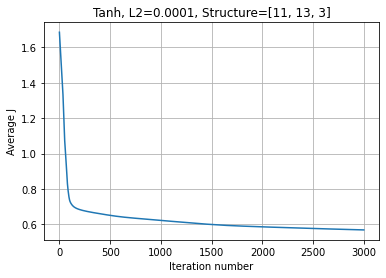

Tanh, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.541984732824424%


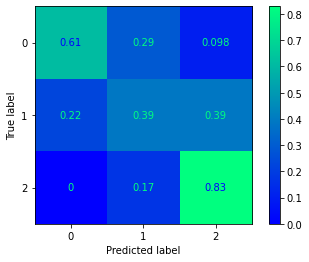

              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        41
         1.0       0.50      0.39      0.44        49
         2.0       0.60      0.83      0.69        41
		 R2 Score: 0.20731707317073167



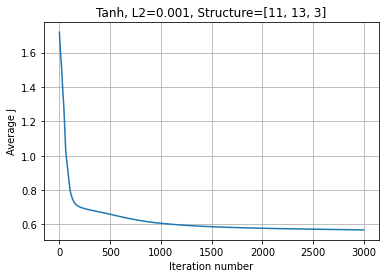

Tanh, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 60.30534351145038%


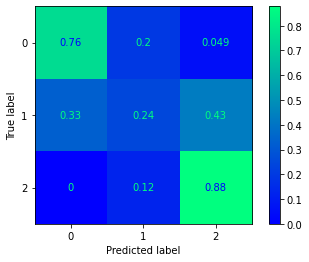

              precision    recall  f1-score   support

         0.0       0.66      0.76      0.70        41
         1.0       0.48      0.24      0.32        49
         2.0       0.61      0.88      0.72        41
		 R2 Score: 0.29268292682926833



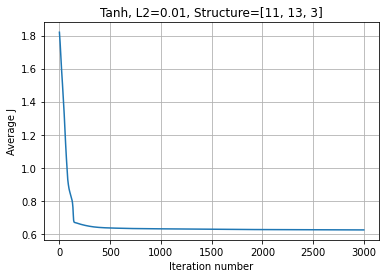

Tanh, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.48854961832062%


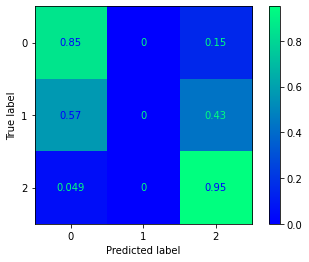

              precision    recall  f1-score   support

         0.0       0.54      0.85      0.66        41
         1.0       0.00      0.00      0.00        49
         2.0       0.59      0.95      0.73        41
		 R2 Score: 0.012195121951219523



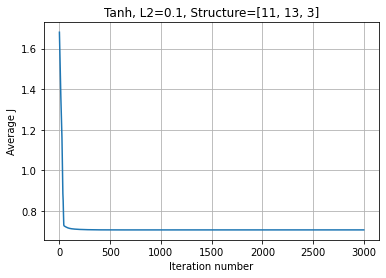

In [265]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

# Train White Wines Data

In [266]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_white)

Original y hist: (array([   0,    0,    0,   20,  163, 1457, 2198,  880,  180]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
Current y hist: (array([1060, 1060, 1060]), array([-0.5,  0.5,  1.5,  2.5]))
y min: 0.0, y max: 2.0
The shape of the wines dataset: (4898, 12)
y[:10]:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X[:10, :]:
[[7.6000e+00 2.9000e-01 2.6000e-01 6.5000e+00 4.2000e-02 3.2000e+01
  1.6000e+02 9.9440e-01 3.1400e+00 4.7000e-01 1.0700e+01]
 [8.1000e+00 3.3000e-01 2.2000e-01 5.2000e+00 4.7000e-02 2.4000e+01
  1.5100e+02 9.9527e-01 3.2200e+00 4.7000e-01 1.0300e+01]
 [6.4000e+00 2.6000e-01 2.6000e-01 1.1000e+00 5.2000e-02 2.2000e+01
  1.7600e+02 9.9304e-01 3.0900e+00 5.4000e-01 9.3000e+00]
 [6.3000e+00 3.2000e-01 3.2000e-01 1.5000e+00 3.0000e-02 2.4000e+01
  1.0100e+02 9.8923e-01 3.2100e+00 4.2000e-01 1.3000e+01]
 [6.8000e+00 3.0000e-01 2.2000e-01 6.2000e+00 6.0000e-02 4.1000e+01
  1.9000e+02 9.9858e-01 3.1800e+00 5.1000e-01 9.2000e+00]
 [8.0000e+00 6.1000e-01 3.8000e-01 1.2100e+01 3.0100e-01

Number of samples: 3180
Sigmoid, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 57.38993710691824%


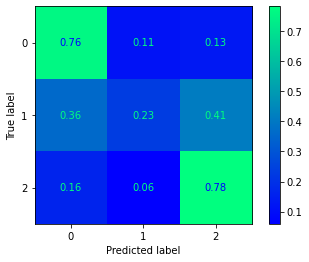

              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65       204
         1.0       0.60      0.23      0.33       231
         2.0       0.56      0.78      0.66       201
		 R2 Score: -0.09880382496476692



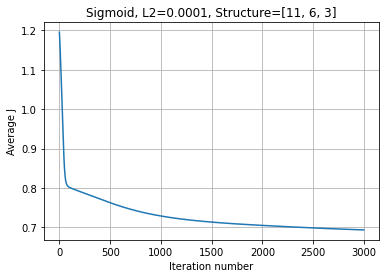

Sigmoid, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.132075471698116%


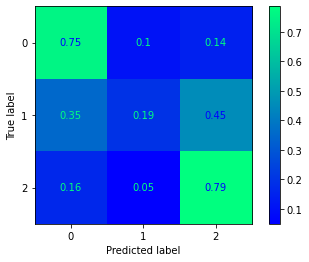

              precision    recall  f1-score   support

         0.0       0.57      0.75      0.65       204
         1.0       0.59      0.19      0.29       231
         2.0       0.54      0.79      0.64       201
		 R2 Score: -0.14818826653621708



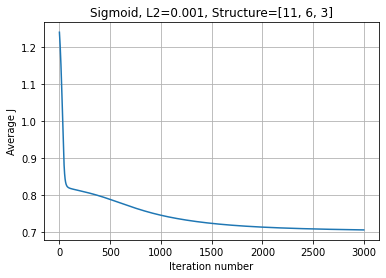

Sigmoid, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.685534591194966%


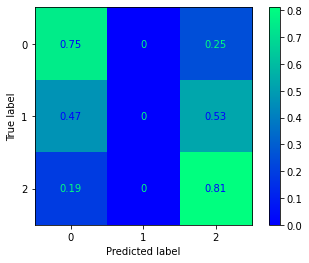

              precision    recall  f1-score   support

         0.0       0.51      0.75      0.61       204
         1.0       0.00      0.00      0.00       231
         2.0       0.49      0.81      0.61       201
		 R2 Score: -0.44943336012206325



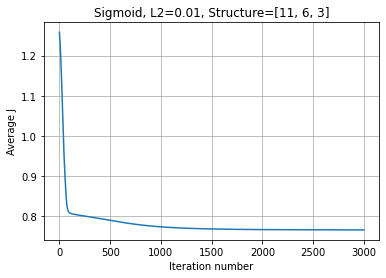

Sigmoid, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.60377358490566%


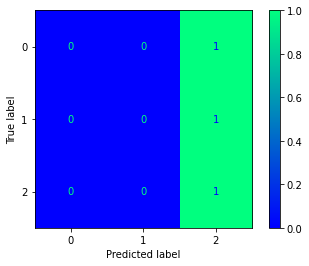

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       204
         1.0       0.00      0.00      0.00       231
         2.0       0.32      1.00      0.48       201
		 R2 Score: -1.5852755162654177



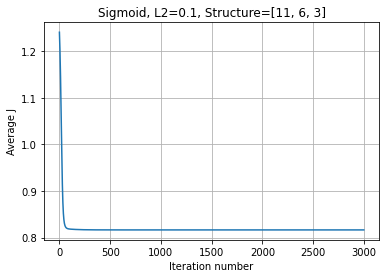

Sigmoid, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 57.23270440251572%


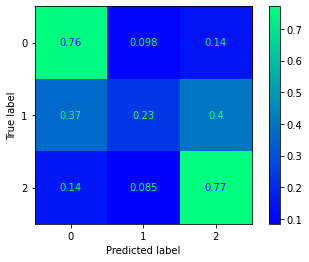

              precision    recall  f1-score   support

         0.0       0.58      0.76      0.66       204
         1.0       0.59      0.23      0.33       231
         2.0       0.56      0.77      0.65       201
		 R2 Score: -0.09386538080762197



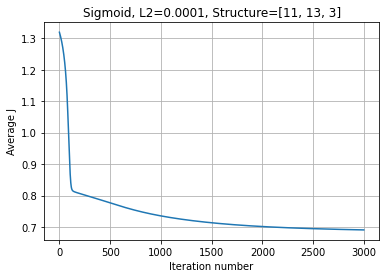

Sigmoid, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.132075471698116%


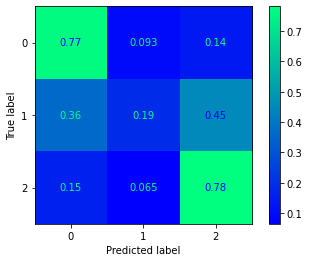

              precision    recall  f1-score   support

         0.0       0.58      0.77      0.66       204
         1.0       0.57      0.19      0.28       231
         2.0       0.54      0.78      0.64       201
		 R2 Score: -0.1259652678290646



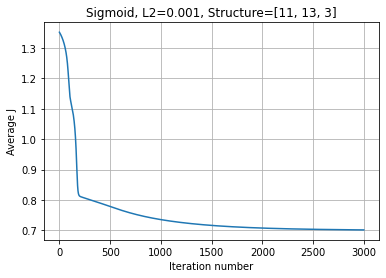

Sigmoid, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 50.0%


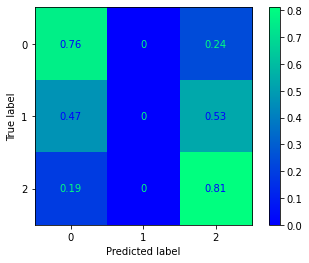

              precision    recall  f1-score   support

         0.0       0.51      0.76      0.61       204
         1.0       0.00      0.00      0.00       231
         2.0       0.49      0.81      0.61       201
		 R2 Score: -0.42967958349348323



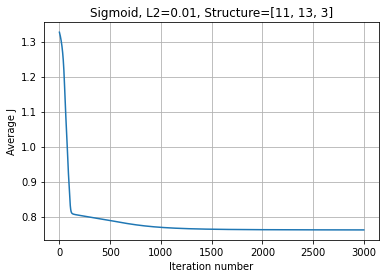

Sigmoid, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.60377358490566%


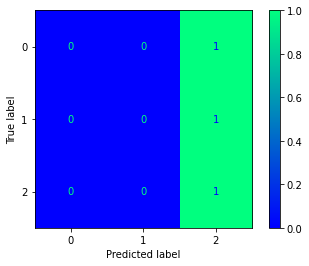

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       204
         1.0       0.00      0.00      0.00       231
         2.0       0.32      1.00      0.48       201
		 R2 Score: -1.5852755162654177



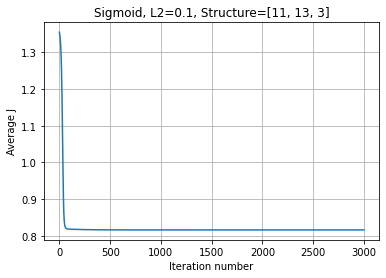

Tanh, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.74842767295597%


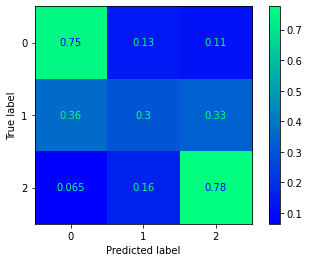

              precision    recall  f1-score   support

         0.0       0.61      0.75      0.68       204
         1.0       0.54      0.30      0.39       231
         2.0       0.61      0.78      0.68       201
		 R2 Score: 0.10120316339960633



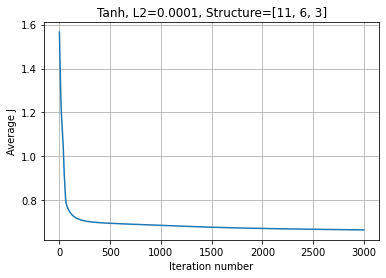

Tanh, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 58.9622641509434%


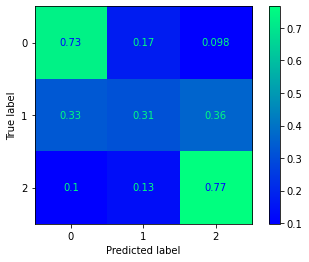

              precision    recall  f1-score   support

         0.0       0.61      0.73      0.66       204
         1.0       0.54      0.31      0.39       231
         2.0       0.60      0.77      0.67       201
		 R2 Score: 0.0592263880638737



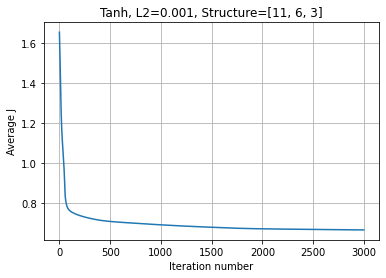

Tanh, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 58.80503144654088%


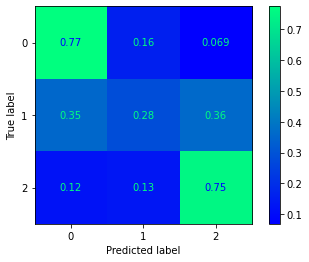

              precision    recall  f1-score   support

         0.0       0.60      0.77      0.68       204
         1.0       0.53      0.28      0.37       231
         2.0       0.61      0.75      0.67       201
		 R2 Score: 0.0715724984567363



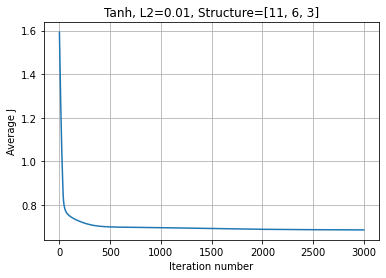

Tanh, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 50.786163522012586%


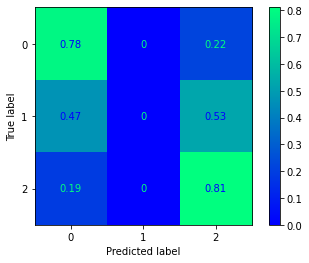

              precision    recall  f1-score   support

         0.0       0.52      0.78      0.63       204
         1.0       0.00      0.00      0.00       231
         2.0       0.50      0.81      0.62       201
		 R2 Score: -0.38029514192203306



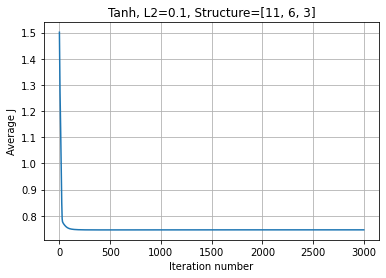

Tanh, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.59119496855346%


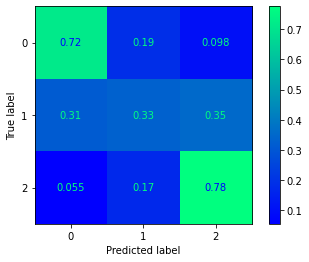

              precision    recall  f1-score   support

         0.0       0.64      0.72      0.67       204
         1.0       0.52      0.33      0.41       231
         2.0       0.60      0.78      0.68       201
		 R2 Score: 0.13577227249962154



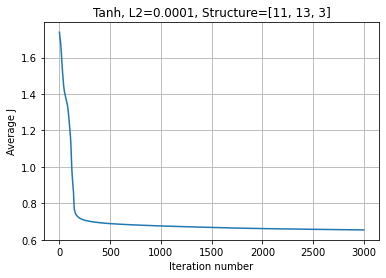

Tanh, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 61.16352201257862%


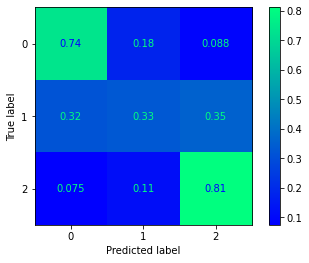

              precision    recall  f1-score   support

         0.0       0.63      0.74      0.68       204
         1.0       0.56      0.33      0.42       231
         2.0       0.62      0.81      0.70       201
		 R2 Score: 0.14564916081391155



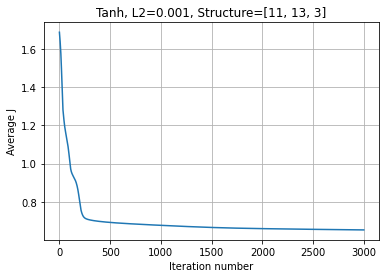

Tanh, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 58.333333333333336%


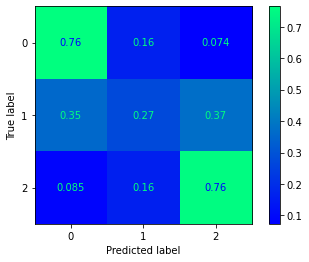

              precision    recall  f1-score   support

         0.0       0.61      0.76      0.68       204
         1.0       0.49      0.27      0.35       231
         2.0       0.60      0.76      0.67       201
		 R2 Score: 0.10861082963532387



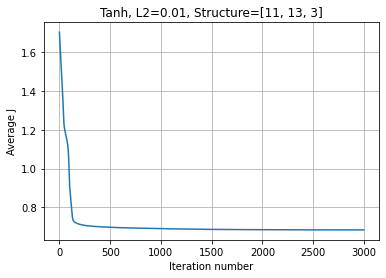

Tanh, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 50.786163522012586%


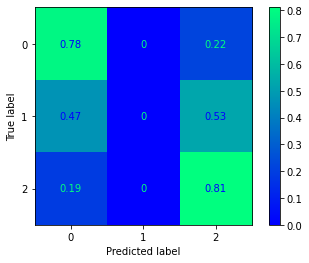

              precision    recall  f1-score   support

         0.0       0.52      0.78      0.63       204
         1.0       0.00      0.00      0.00       231
         2.0       0.50      0.81      0.62       201
		 R2 Score: -0.38029514192203306



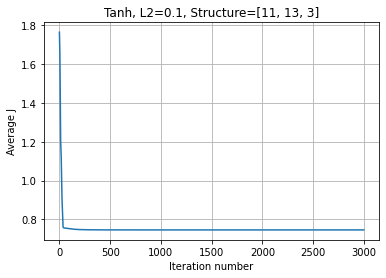

In [267]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

# Train All Wines Data

In [268]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_all)

Original y hist: (array([   0,    0,    0,   30,  216, 2138, 2836, 1079,  198]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
Current y hist: (array([1277, 1277, 1277]), array([-0.5,  0.5,  1.5,  2.5]))
y min: 0.0, y max: 2.0
The shape of the wines dataset: (6497, 12)
y[:10]:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X[:10, :]:
[[6.0000e+00 2.0000e-01 2.4000e-01 5.3000e+00 7.5000e-02 4.9000e+01
  2.0100e+02 9.9466e-01 3.2100e+00 4.3000e-01 9.5000e+00]
 [5.7000e+00 2.5500e-01 6.5000e-01 1.2000e+00 7.9000e-02 1.7000e+01
  1.3700e+02 9.9307e-01 3.2000e+00 4.2000e-01 9.4000e+00]
 [7.5000e+00 2.2000e-01 2.9000e-01 4.8000e+00 5.0000e-02 3.3000e+01
  8.7000e+01 9.9400e-01 3.1400e+00 4.2000e-01 9.9000e+00]
 [7.8000e+00 2.8000e-01 3.1000e-01 2.1000e+00 4.6000e-02 2.8000e+01
  2.0800e+02 9.9434e-01 3.2300e+00 6.4000e-01 9.8000e+00]
 [6.4000e+00 2.3000e-01 3.5000e-01 1.0300e+01 4.2000e-02 5.4000e+01
  1.4000e+02 9.9670e-01 3.2300e+00 4.7000e-01 9.2000e+00]
 [1.2500e+01 4.6000e-01 6.3000e-01 2.0000e+00 7.1000e-02

Number of samples: 3831
Sigmoid, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.19165580182529%


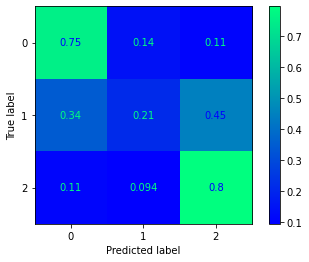

              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70       275
         1.0       0.46      0.21      0.29       247
         2.0       0.58      0.80      0.67       245
		 R2 Score: 0.07290797607679544



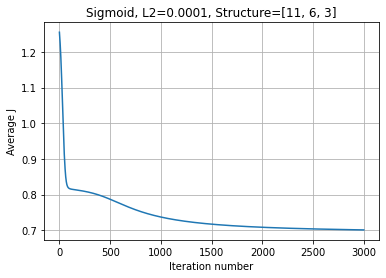

Sigmoid, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.0612777053455%


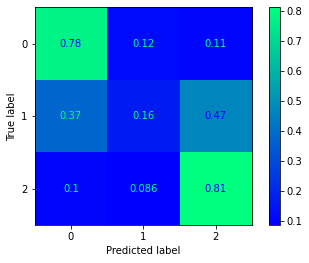

              precision    recall  f1-score   support

         0.0       0.65      0.78      0.71       275
         1.0       0.43      0.16      0.24       247
         2.0       0.58      0.81      0.68       245
		 R2 Score: 0.08254510730260844



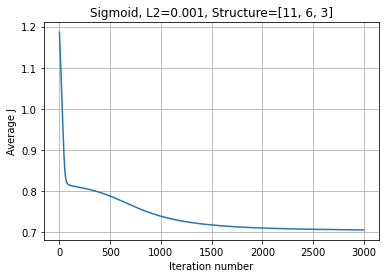

Sigmoid, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.975228161668845%


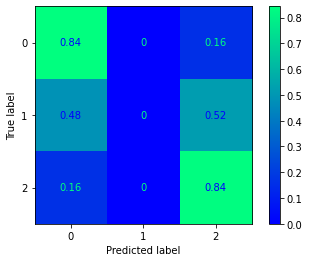

              precision    recall  f1-score   support

         0.0       0.59      0.84      0.70       275
         1.0       0.00      0.00      0.00       247
         2.0       0.55      0.84      0.66       245
		 R2 Score: -0.11597979594913799



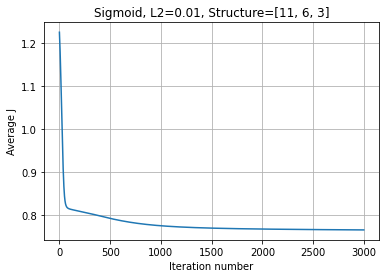

Sigmoid, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.94263363754889%


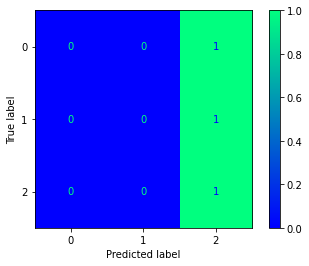

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       275
         1.0       0.00      0.00      0.00       247
         2.0       0.32      1.00      0.48       245
		 R2 Score: -1.5962431522340053



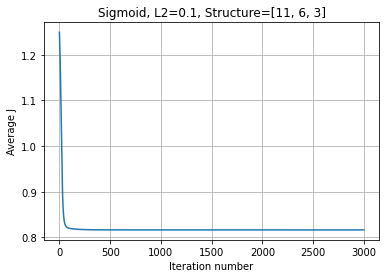

Sigmoid, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.19165580182529%


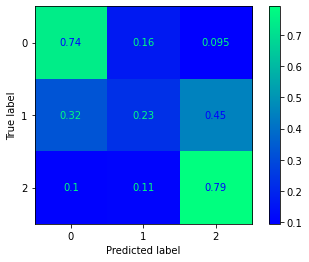

              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70       275
         1.0       0.44      0.23      0.30       247
         2.0       0.59      0.79      0.67       245
		 R2 Score: 0.10181936975423433



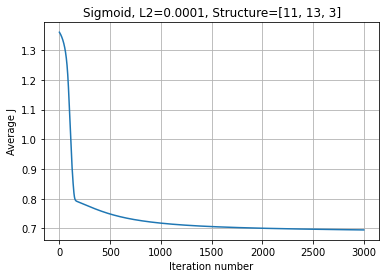

Sigmoid, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 59.45241199478487%


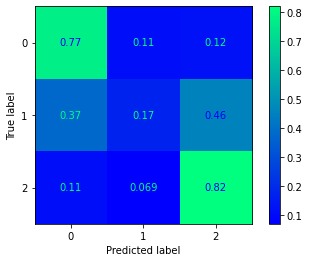

              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70       275
         1.0       0.47      0.17      0.25       247
         2.0       0.58      0.82      0.68       245
		 R2 Score: 0.05941599236065731



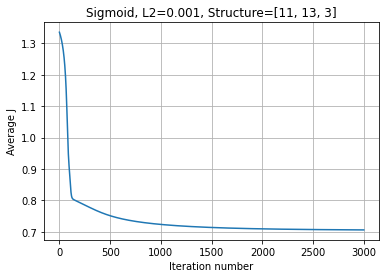

Sigmoid, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 57.10560625814863%


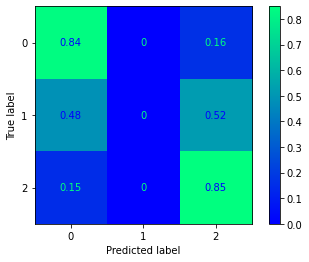

              precision    recall  f1-score   support

         0.0       0.60      0.84      0.70       275
         1.0       0.00      0.00      0.00       247
         2.0       0.55      0.85      0.66       245
		 R2 Score: -0.10827009096848772



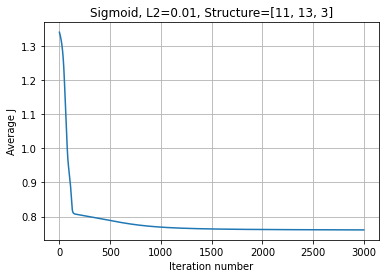

Sigmoid, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 31.94263363754889%


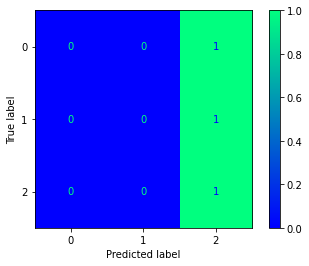

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       275
         1.0       0.00      0.00      0.00       247
         2.0       0.32      1.00      0.48       245
		 R2 Score: -1.5962431522340053



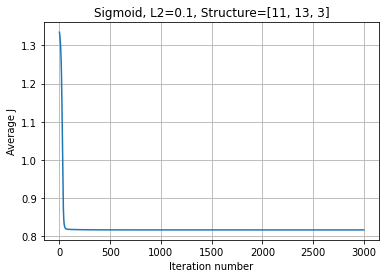

Tanh, L2=0.0001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 60.36505867014341%


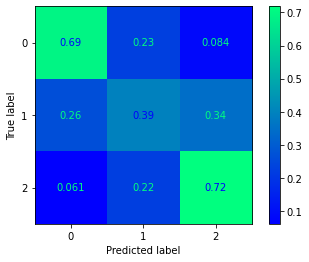

              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70       275
         1.0       0.46      0.39      0.42       247
         2.0       0.62      0.72      0.67       245
		 R2 Score: 0.19433582952203843



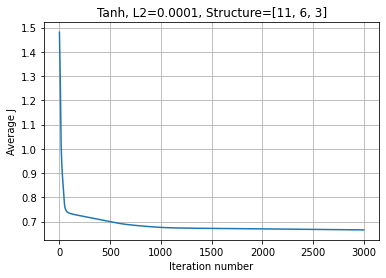

Tanh, L2=0.001, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 60.625814863103%


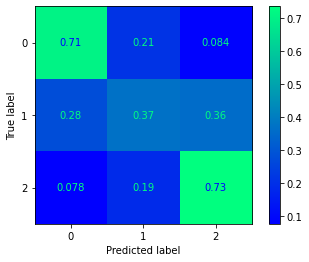

              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70       275
         1.0       0.47      0.37      0.41       247
         2.0       0.62      0.73      0.67       245
		 R2 Score: 0.17506156707041265



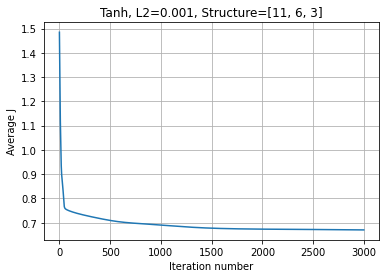

Tanh, L2=0.01, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 60.36505867014341%


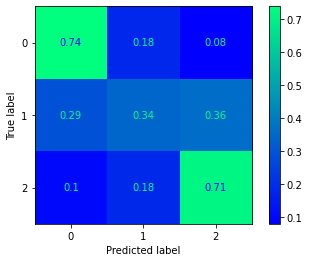

              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71       275
         1.0       0.47      0.34      0.40       247
         2.0       0.61      0.71      0.66       245
		 R2 Score: 0.14229532090264863



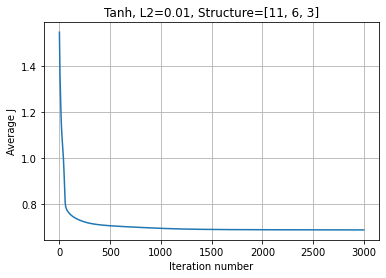

Tanh, L2=0.1, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 57.6271186440678%


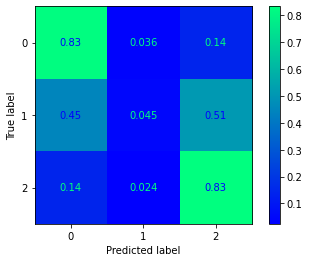

              precision    recall  f1-score   support

         0.0       0.61      0.83      0.70       275
         1.0       0.41      0.04      0.08       247
         2.0       0.55      0.83      0.67       245
		 R2 Score: -0.04851987736844743



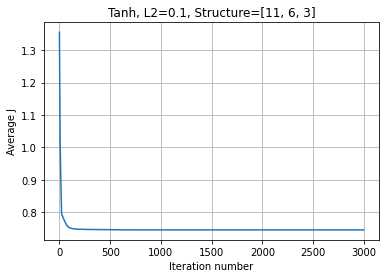

Tanh, L2=0.0001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 62.84224250325945%


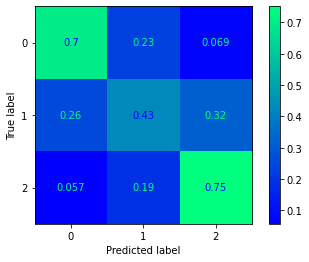

              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71       275
         1.0       0.49      0.43      0.46       247
         2.0       0.65      0.75      0.70       245
		 R2 Score: 0.2598683218575665



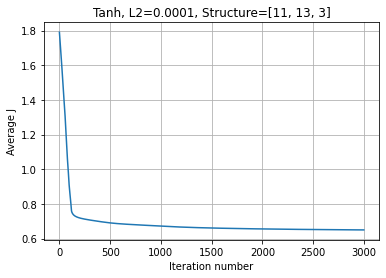

Tanh, L2=0.001, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 64.01564537157758%


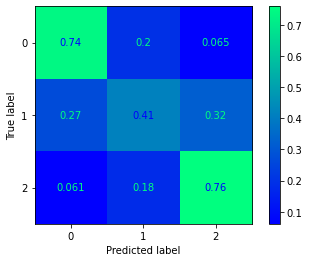

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.73       275
         1.0       0.51      0.41      0.46       247
         2.0       0.66      0.76      0.70       245
		 R2 Score: 0.27721515806402974



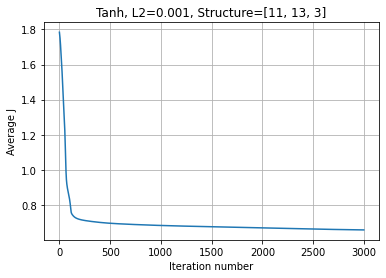

Tanh, L2=0.01, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 61.408083441981745%


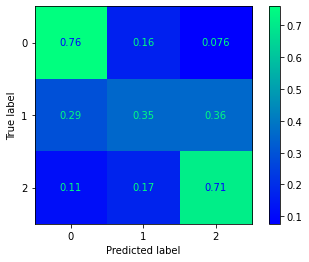

              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       275
         1.0       0.50      0.35      0.41       247
         2.0       0.62      0.71      0.66       245
		 R2 Score: 0.14615017339297376



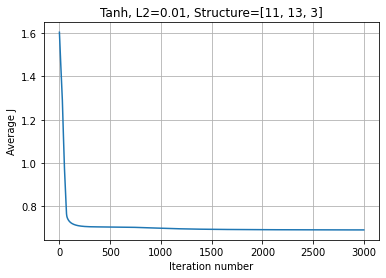

Tanh, L2=0.1, Structure=[11, 13, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 57.887874837027375%


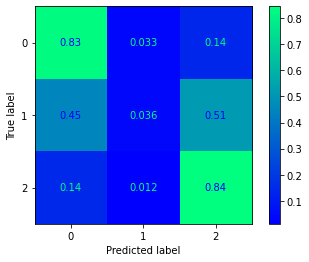

              precision    recall  f1-score   support

         0.0       0.61      0.83      0.70       275
         1.0       0.43      0.04      0.07       247
         2.0       0.56      0.84      0.67       245
		 R2 Score: -0.044665024878122406



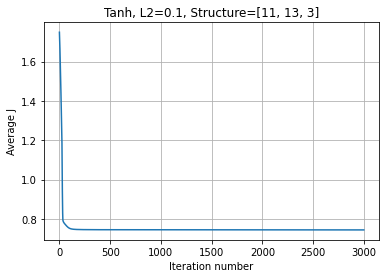

In [269]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

### Run performance analysis

In [270]:
# nn_performance('Sigmoid Activation Function', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv)
# Section a
# nn_performance('Sigmoid, L2 Regularization (lambda=0.01)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, 0.01)
# Section b
# nn_performance('ReLU Activation Function',[11, 6, 3], X_train, y_v_train, X_test, y_test, 500, re_lu, re_lu_deriv)
# Section c
# nn_performance('Tanh Activation Function', [11, 6, 3], X_train, y_v_train, X_test, y_test, 3000, tanh, tanh_deriv)
# Section d
# nn_performance('Soft-plus Activation Function', [11, 6, 3], X_train, y_v_train, X_test, y_test, 500, soft_plus, soft_plus_deriv)
# Section e
# nn_performance('Sigmoid, 4000 Iterations (Not 3000)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations + 1000, f, f_deriv)
# Section f
# diff_nn_structure = [X.shape[1], 16, y_out_len]
# nn_performance('Sigmoid, NN Structure = [11, 45 (Not 30), 10]', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv)

# for i in list(range(6, 7)) + list(range(11, 14)):
#     nn_structure[1] = i
#     print(f'Using NN Structure: {nn_structure}')
#     nn_performance('Sigmoid, L2 Regularization (lambda=0.001)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, 0.001)

# Checking different l2 lambdas
# for l2_lambda in [0.0008]:
#     nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn_structure}', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)

# Checking different NN structures
# for nn in [nn_structure, [X.shape[1], 13, 11, y_out_len], [X.shape[1], 13, 6, y_out_len], [X.shape[1], 13, 3, y_out_len]]: # [11, 13, 3]]
#     nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn}', nn, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)